# Location regression with only smooth terms

In [1]:
import jax
import jax.numpy as jnp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
import os

# Set path such that interpreter finds tigerpy
sys.path.append(os.path.join(os.getcwd(), ".."))

import tigerpy.model as tiger
import tigerpy.bbvi as bbvi
from tigerpy.distributions import MultivariateNormalDegenerate

# We use distributions and bijectors from tensorflow probability
import tensorflow_probability.substrates.jax.distributions as tfjd
import tensorflow_probability.substrates.jax.bijectors as tfjb

rng = np.random.default_rng(42)

# Load the data
df = pd.read_csv('../data/dbbmi.csv', sep=',')

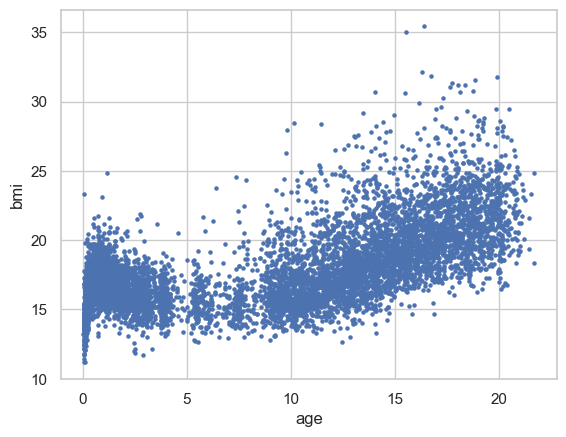

In [2]:
# Plot the data
sns.set_theme(style="whitegrid")
df.plot(kind = "scatter", x = "age", y = "bmi", s = 5)
plt.show()

In [3]:
# Set up design matrix 
X = tiger.Obs(name="X_loc", intercept=False)
X.smooth(data=df["age"].to_numpy(), n_knots=20)

# Set up hyperparameters for the beta_scale  
tau2_a = tiger.Hyper(1.0, name="tau2_a")
tau2_b = tiger.Hyper(0.00005, name="tau2_b")
tau2_dist = tiger.Dist(tfjd.InverseGamma, concentration=tau2_a, scale=tau2_b)
tau2 = tiger.Param(value=1.0, distribution=tau2_dist, param_space="positive", name="tau2")

# Set up hyperparameters for the smooth effect 
beta_smooth_loc = tiger.Hyper(jnp.zeros(X.smooth_dim[0]), name="beta_smooth_loc")

# Define the penaly matrix from class Obs
pen = tiger.Hyper(X.smooth_pen_mat[0], name="beta_smooth_pen")

# Set up parameters 
beta_smooth_dist = tiger.Dist(MultivariateNormalDegenerate, loc=beta_smooth_loc, var=tau2, pen=pen)
beta_smooth = tiger.Param(value=jnp.repeat(df["bmi"].to_numpy().mean(), X.smooth_dim[0]), distribution=beta_smooth_dist, name="beta_smooth")

# Set up hyperparameters for the scale  
sigma_a = tiger.Hyper(0.01, name="sigma_a")
sigma_b = tiger.Hyper(0.01, name="sigma_b")

sigma_dist = tiger.Dist(tfjd.InverseGamma, concentration=sigma_a, scale=sigma_b)
sigma = tiger.Param(value=10.0, distribution=sigma_dist, param_space="positive", name="sigma")

# Set up the linear predictor 
lpred = tiger.Lpred(obs=X, beta_smooth=beta_smooth)

# Set up response distribution
response_dist = tiger.Dist(tfjd.Normal, loc=lpred, scale=sigma)
m = tiger.Model(response=df["bmi"].to_numpy(), distribution=response_dist)

In [4]:
m.log_prob

Array(-23834.705, dtype=float32)

In [5]:
graph = tiger.ModelGraph(model=m)
graph.build_graph()

In [6]:
graph.logprob()

Array(-23834.705, dtype=float32)

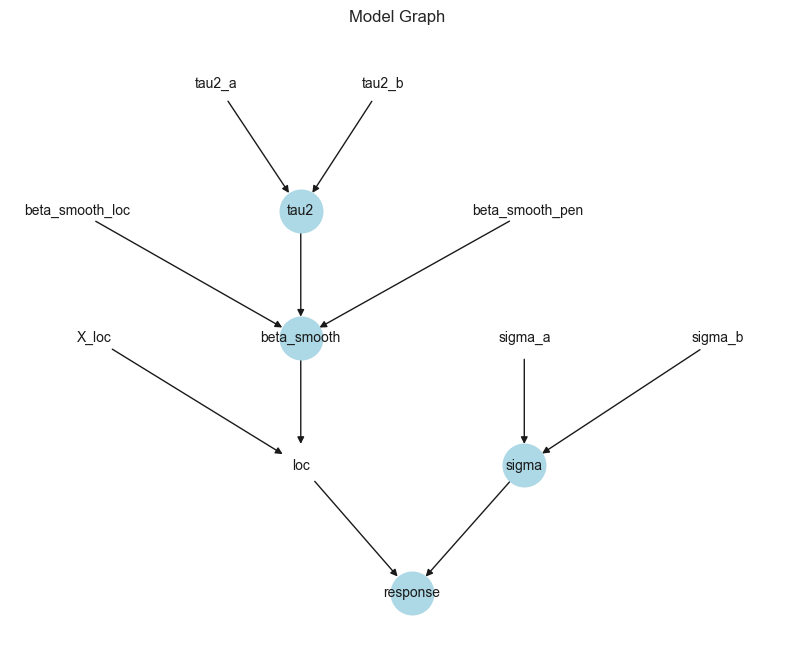

In [7]:
graph.visualize_graph()

## Inference with Bbvi

In [17]:
q = bbvi.Bbvi(graph=graph)

In [18]:
q.run_bbvi(step_size=0.01,
           threshold=1e-2,
           key_int=1,
           batch_size=256,
           num_var_samples=64,
           chunk_size=50,
           epochs=500)

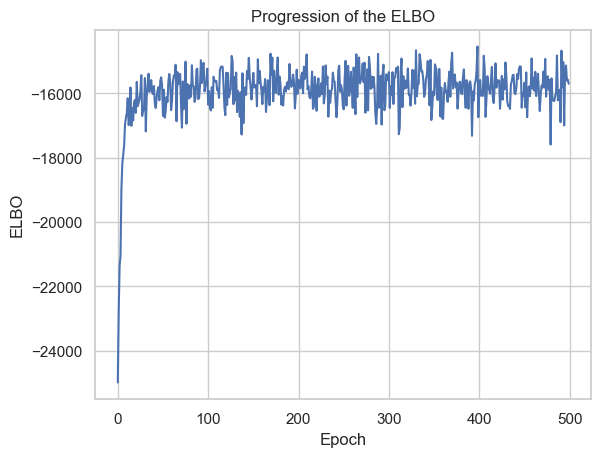

In [19]:
q.plot_elbo()

In [20]:
q.return_loc_params

{'tau2': {'loc': Array([-1.3293118], dtype=float32)},
 'sigma': {'loc': Array([0.7471426], dtype=float32)},
 'beta_smooth': {'loc': Array([17.14965 , 15.947874, 15.104371, 15.870909, 15.784521, 15.740833,
         15.956091, 16.298775, 16.579184, 16.852564, 17.408985, 17.925934,
         18.4855  , 19.125689, 19.591434, 20.158123, 20.83092 , 21.359493,
         21.732162, 21.965937], dtype=float32)}}

## Visualize the regression line 

In [21]:
b = q.trans_var_params["beta_smooth"]["loc"]
b

Array([17.14965 , 15.947874, 15.104371, 15.870909, 15.784521, 15.740833,
       15.956091, 16.298775, 16.579184, 16.852564, 17.408985, 17.925934,
       18.4855  , 19.125689, 19.591434, 20.158123, 20.83092 , 21.359493,
       21.732162, 21.965937], dtype=float32)

In [22]:
# plot the regression line 
b = q.trans_var_params["beta_smooth"]["loc"]
x_new = jnp.linspace(df["age"].to_numpy().min(), df["age"].to_numpy().max(), num=100)
X_new = tiger.Obs(name="X_pred", intercept=False)
X_new.smooth(data = x_new, n_knots=20)
y = X_new.design_matrix @ b

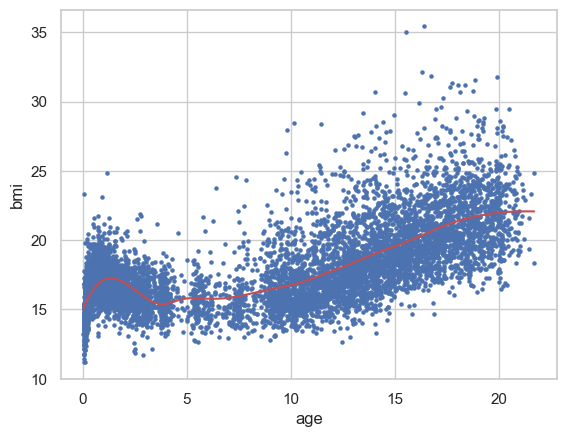

In [23]:
# plot the data
fig, ax = plt.subplots()

df.plot(kind="scatter", x="age", y="bmi", s=5, ax=ax)
ax.plot(x_new, y, color = "r")
#ax.plot(df["age"].to_numpy(), y, color = "r")
plt.show()

In [30]:
tau2 = q.trans_var_params["tau2"]["loc"]
s = q.trans_var_params["tau2"]["cov"]

In [31]:
tau2, s

(Array([-1.3293118], dtype=float32), Array([[0.10130346]], dtype=float32))

In [32]:
mean = jnp.exp(tau2 + s/2)
mean

Array([[0.2784101]], dtype=float32)

In [33]:
1 / (mean)

Array([[3.5918236]], dtype=float32)